### Assignment 7 (Week 9)

### Name: Eunice Familoye

In [ ]:
- Review Title: The title of the review.
- Review_Text: The full text of the review.
- Verified_Buyer: Whether the reviewer is a verified buyer of the product.
- Review_Date: The date the review was published relative to the review scrape date.
- Review_Location: The location of the reviewer.
- Review_Upvotes: How many times the review was upvoted by other reviewers.
- Review_Downvotes: How many times the review was downvoted by other reviewers.
- Product: The name of the product the review was issued for.
- Brand: The brand of the product.
- Scrape Date: The date the data was pulled from the web.

### Objectives

In [ ]:
1. Exploratory Data Analysis.

2. Research and experimentation.

3. Sentiments Analysis.

## Note: 

- The assignment **should** be submitted through a `public` GitHub repository.

In [30]:
# Import libraries

# Conventional libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Optional, Sequence, Union


# Setting pandas display
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000

# Other modules
import json, re, pickle

# MLFlow
import mlflow

# Model selection
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, cross_validate, 
                                     GridSearchCV, RandomizedSearchCV, KFold,
                                     cross_val_predict)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline

# Model evaluation
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score, log_loss, precision_score,
                             recall_score, auc, RocCurveDisplay)

# For feature preprocessing and normalizing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder

# Feature selection technique
from sklearn.feature_selection import (SelectKBest, chi2, mutual_info_classif, f_classif)

# Resampling technique for imbalance dataset
from imblearn.over_sampling import RandomOverSampler,SMOTENC,SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

# Handling warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

###  Qs 1. Explore the data. What can the reviews tell us about the products? Do most buyers have common skincare issues? What issues did the products help solve or exacerbate?

In [25]:
def load_data(*, filename: str, sep: str = ",") -> pd.DataFrame:
    """This is used to load the data.

    NB: Supported formats are 'csv' and 'parquet'.

    Params;
        filename (str): The filepath.
        sep (str, default=","): The separator. e.g ',', '\t', etc

    Returns:
        data (pd.DataFrame): The loaded dataframe.
    """
    df = (
        pd.read_csv(filename, sep=sep)
        if filename.split(".")[-1] == "csv"
        else pd.read_parquet(filename)
    )
    print(f"Shape of df: {df.shape}\n")
    return df

In [8]:
# Load dataset
df = pd.read_csv("Desktop/SGA1_4/Ulta Skincare Reviews.csv")
df.head(3)

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower...,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
1,You need this,Even better than the daily microfoliant. I'm o...,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
2,Clean skin,Enjoy this product so much ! I look forward to...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023


In [10]:
df.columns

Index(['Review_Title', 'Review_Text', 'Verified_Buyer', 'Review_Date',
       'Review_Location', 'Review_Upvotes', 'Review_Downvotes', 'Product',
       'Brand', 'Scrape_Date'],
      dtype='object')

In [20]:
df.nunique()

Review_Title        2828
Review_Text         3661
Verified_Buyer         2
Review_Date           41
Review_Location     1423
Review_Upvotes        23
Review_Downvotes      15
Product                4
Brand                  1
Scrape_Date            1
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4150 entries, 0 to 4149
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review_Title      4150 non-null   object
 1   Review_Text       4148 non-null   object
 2   Verified_Buyer    4150 non-null   object
 3   Review_Date       4150 non-null   object
 4   Review_Location   4149 non-null   object
 5   Review_Upvotes    4150 non-null   int64 
 6   Review_Downvotes  4150 non-null   int64 
 7   Product           4150 non-null   object
 8   Brand             4150 non-null   object
 9   Scrape_Date       4150 non-null   object
dtypes: int64(2), object(8)
memory usage: 324.3+ KB


In [23]:
df.isna().sum()

Review_Title        0
Review_Text         2
Verified_Buyer      0
Review_Date         0
Review_Location     1
Review_Upvotes      0
Review_Downvotes    0
Product             0
Brand               0
Scrape_Date         0
dtype: int64

In [26]:
ID = 200

df["Review_Text"].iat[ID], df["Verified_Buyer"].iat[ID]

("Clear skin rthequires exfoliation. This one warms your skin to open pores and gently exfoliates. I use it 2 times a week and everyone comments that my skin doesn't look its 60 years of age. Well worth the money.",
 'Yes')

In [28]:
# Load spaCy Model

import spacy

nlp = spacy.load("en_core_web_sm")


text = df["Review_Text"].iat[ID]

In [31]:
class Tokenizer:
    """This is used to tokenize documents"""

    def __init__(self) -> None:
        self.nlp = nlp

    def __call__(self, doc: str, *args: Any, **kwargs: Any) -> list[str]:
        # Tokenize
        doc = nlp(doc)
        tokenized_doc = [word.text.lower() for word in doc]
        return tokenized_doc


class BagOfWords:
    """This tokenizes all the documents and calculates the bag of words.
    i.e all the unique words in the document are stored and counted.

    Returns:
        tokenized_docs (list[int]): Tokenized documents i.e list of
            tokenized documents where every row in the data is a document.
        bag_of_words (dict[str, int]): A dict containing a unique word and the
            unique numeric representation of the word.
    """

    def __init__(self) -> None:
        self.tokenizer = Tokenizer()

    def __call__(
        self, data: pd.DataFrame, *args: Any, **kwargs: Any
    ) -> tuple[list, dict[str, Any]]:
        """This calculates the bag of words."""
        count = 0
        vocabulary = {}
        all_tokenized_docs = []

        for doc in data:
            # Tokenize docs
            tokenized_doc = self.tokenizer(doc=doc)
            doc_as_num = []

            for word in tokenized_doc:
                # Store the unique words as numbers in the dict
                if word not in vocabulary:
                    vocabulary[word] = count
                    count += 1
                # Save the word as a number
                doc_as_num.append(vocabulary.get(word))
            # Store the tokenized docs (converted to numbers) in a list
            all_tokenized_docs.append(doc_as_num)
        return (all_tokenized_docs, vocabulary)

In [32]:
df = df.iloc[:3]

df

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower...,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
1,You need this,Even better than the daily microfoliant. I'm o...,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
2,Clean skin,Enjoy this product so much ! I look forward to...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023


In [35]:
# Initialize
bow = BagOfWords()

# Call the function
tokenized_docs, vocabulary = bow(data=df["Review_Text"])

print(f"Total number of documents: {len(tokenized_docs)}\n")
print(tokenized_docs)

Total number of documents: 3

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [19, 20, 21, 8, 22, 23, 10, 24, 25, 26, 10, 4, 27, 28, 29, 30, 31], [32, 2, 33, 29, 30, 34, 24, 35, 36, 37, 1, 38, 39, 40, 41, 42, 10]]


In [38]:

vocabulary

{'love': 0,
 'using': 1,
 'this': 2,
 'on': 3,
 'my': 4,
 'face': 5,
 'while': 6,
 'in': 7,
 'the': 8,
 'shower': 9,
 '.': 10,
 'heats': 11,
 'up': 12,
 'and': 13,
 'gives': 14,
 'a': 15,
 'light': 16,
 'scrub': 17,
 'nicely': 18,
 'even': 19,
 'better': 20,
 'than': 21,
 'daily': 22,
 'microfoliant': 23,
 'i': 24,
 "'m": 25,
 'obsessed': 26,
 'skin': 27,
 'is': 28,
 'so': 29,
 'much': 30,
 'smoother': 31,
 'enjoy': 32,
 'product': 33,
 '!': 34,
 'look': 35,
 'forward': 36,
 'to': 37,
 'it': 38,
 '-': 39,
 'really': 40,
 'feels': 41,
 'great': 42}

In [40]:
# 1st sentence
df["Review_Text"].iat[0]

'Love using this on my face while in the shower. Heats up and gives a light scrub nicely'

In [41]:
print(tokenized_docs[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [42]:
shape = len(tokenized_docs), len(vocabulary)
arr = np.zeros(shape=shape, dtype=int)
arr, arr.shape

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 (3, 43))

In [43]:
# Convert to Array

tokenized_docs

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [19, 20, 21, 8, 22, 23, 10, 24, 25, 26, 10, 4, 27, 28, 29, 30, 31],
 [32, 2, 33, 29, 30, 34, 24, 35, 36, 37, 1, 38, 39, 40, 41, 42, 10]]

In [44]:
# Replicate Sklearn's Count Vectorizer
for idx, tok_doc in enumerate(tokenized_docs):
    for token in tok_doc:
        arr[idx, token] += 1

In [45]:
arr

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [46]:
# Term Frequency

term_freq_df = pd.DataFrame(arr, columns=vocabulary.keys())
term_freq_df


,love,using,this,on,my,face,while,in,the,shower,.,heats,up,and,gives,a,light,scrub,nicely,even,better,than,daily,microfoliant,i,'m,obsessed,skin,is,so,much,smoother,enjoy,product,!,look,forward,to,it,-,really,feels,great
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1


In [47]:
df["Review_Text"]

0    Love using this on my face while in the shower...
1    Even better than the daily microfoliant. I'm o...
2    Enjoy this product so much ! I look forward to...
Name: Review_Text, dtype: object

In [48]:
df["Review_Text"].shape[0]

3

In [50]:
text = df["Review_Text"].iat[0]
text = text.split()

text[:3]

['Love', 'using', 'this']

In [52]:
pd_series = pd.Series(df["Review_Text"].iat[0])
pd_series

0    Love using this on my face while in the shower...
dtype: object

In [53]:
bow = BagOfWords()
tokenized_docs, vocabulary = bow(data=pd_series)

In [54]:
vocabulary

{'love': 0,
 'using': 1,
 'this': 2,
 'on': 3,
 'my': 4,
 'face': 5,
 'while': 6,
 'in': 7,
 'the': 8,
 'shower': 9,
 '.': 10,
 'heats': 11,
 'up': 12,
 'and': 13,
 'gives': 14,
 'a': 15,
 'light': 16,
 'scrub': 17,
 'nicely': 18}

In [55]:
shape = (len(tokenized_docs), len(vocabulary))

arr_1 = np.zeros(shape=shape, dtype=int)
arr_1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [56]:
len(tokenized_docs)

1

In [57]:
# Populate the array
for idx, tok_doc in enumerate(tokenized_docs):
    for token in tok_doc:
        arr_1[idx, token] += 1

In [58]:
pd_series

0    Love using this on my face while in the shower...
dtype: object

In [59]:
# The populated array
arr_1

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [60]:
pd.DataFrame(data=arr_1, columns=vocabulary.keys())

,love,using,this,on,my,face,while,in,the,shower,.,heats,up,and,gives,a,light,scrub,nicely
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [61]:
df

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower...,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
1,You need this,Even better than the daily microfoliant. I'm o...,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
2,Clean skin,Enjoy this product so much ! I look forward to...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023


In [62]:
# Distance: DF=0
N, DF = 3, 0
IDF = N / (DF + 1)

IDF

3.0

In [63]:
np.inf + 1

inf

In [64]:
# Actual value vs log
1_000_000_000_000_000_000_000 / 1_000, np.log(1_000_000_000_000_000_000_000 / 1_000)

(1e+18, 41.44653167389282)

In [65]:
words = ["Review_Text"]
term = words[-1].lower()

term_freq_df

,love,using,this,on,my,face,while,in,the,shower,.,heats,up,and,gives,a,light,scrub,nicely,even,better,than,daily,microfoliant,i,'m,obsessed,skin,is,so,much,smoother,enjoy,product,!,look,forward,to,it,-,really,feels,great
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1


In [68]:
# Document frequency calculations
(term_freq_df > 0)

,love,using,this,on,my,face,while,in,the,shower,.,heats,up,and,gives,a,light,scrub,nicely,even,better,than,daily,microfoliant,i,'m,obsessed,skin,is,so,much,smoother,enjoy,product,!,look,forward,to,it,-,really,feels,great
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False
2,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True


###  Qs 2. Create a wordcloud showing the words/phrases commonly associated with each product.

In [70]:
# Load dataset
df = pd.read_csv("Desktop/SGA1_4/Ulta Skincare Reviews.csv")
df.head(3)

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower...,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
1,You need this,Even better than the daily microfoliant. I'm o...,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
2,Clean skin,Enjoy this product so much ! I look forward to...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023


In [71]:
df[["Review_Text", "Verified_Buyer","Product"]].head()

,Review_Text,Verified_Buyer,Product
0,Love using this on my face while in the shower...,No,Multi-Vitamin Thermafoliant
1,Even better than the daily microfoliant. I'm o...,No,Multi-Vitamin Thermafoliant
2,Enjoy this product so much ! I look forward to...,No,Multi-Vitamin Thermafoliant
3,I've never tried anything like this before and...,No,Multi-Vitamin Thermafoliant
4,This exfoliates very nicely and gives a very s...,No,Multi-Vitamin Thermafoliant


In [78]:
# Groupby by Product
Product = df.groupby("Product")

# Summary statistic of Product
Product.describe().head()

Review_Upvotes                                     \
                                     count      mean       std  min  25%  50%   
Product                                                                         
Daily Microfoliant                  1500.0  0.786667  2.929199  0.0  0.0  0.0   
Daily Superfoliant                  1500.0  0.613333  1.971399  0.0  0.0  0.0   
Hydro Masque Exfoliant               800.0  0.045000  0.292544  0.0  0.0  0.0   
Multi-Vitamin Thermafoliant          350.0  0.908571  1.836493  0.0  0.0  0.0   

                                       Review_Downvotes                      \
                             75%   max            count      mean       std   
Product                                                                       
Daily Microfoliant           1.0  84.0           1500.0  0.221333  1.301848   
Daily Superfoliant           0.0  25.0           1500.0  0.114000  0.607660   
Hydro Masque Exfoliant       0.0   5.0            800.0  0.011250  0.136553   
Multi-Vitamin Thermafoliant  1.0  20.0            350.0  0.448571  0.912464   

                                                       
                             min  25%  50%  75%   max  
Product                                                
Daily Microfoliant           0.0  0.0  0.0  0.0  35.0  
Daily Superfoliant           0.0  0.0  0.0  0.0  11.0  
Hydro Masque Exfoliant       0.0  0.0  0.0  0.0   3.0  
Multi-Vitamin Thermafoliant  0.0  0.0  0.0  1.0   9.0

In [79]:
Product.mean().sort_values(by="Review_Upvotes",ascending=False).head()

,Review_Upvotes,Review_Downvotes
Product,,
Multi-Vitamin Thermafoliant,0.908571,0.448571
Daily Microfoliant,0.786667,0.221333
Daily Superfoliant,0.613333,0.114000
Hydro Masque Exfoliant,0.045000,0.011250


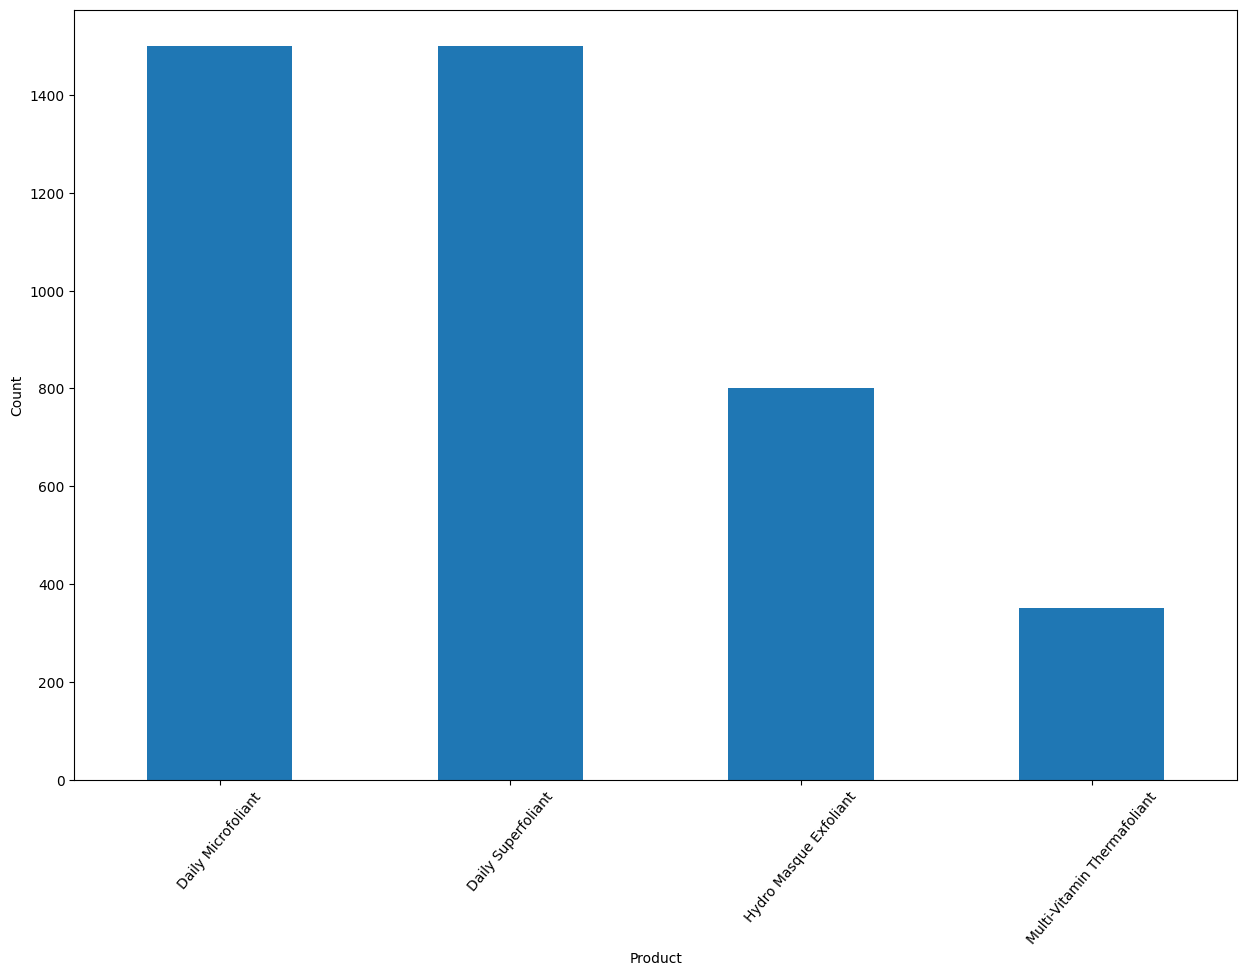

In [80]:
plt.figure(figsize=(15,10))
Product.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Product")
plt.ylabel("Count")
plt.show()

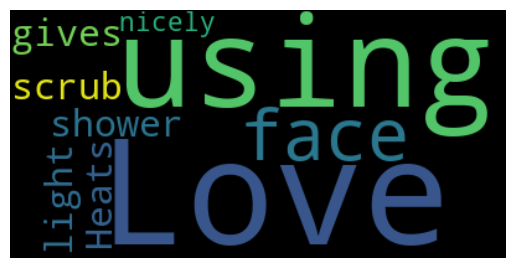

In [86]:
from wordcloud import WordCloud

# Start with one review:
Review_Text = df.Review_Text[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(Review_Text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

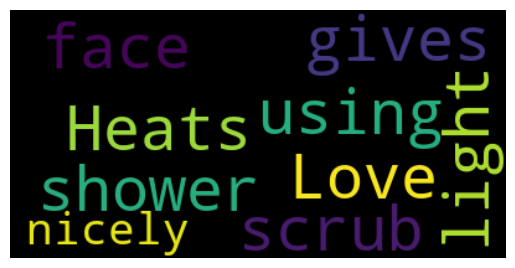

In [87]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(Review_Text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [88]:
Review_Text = " ".join(review for review in df.Product)
print ("There are {} words in the combination of all review.".format(len(Review_Text)))


There are 85199 words in the combination of all review.


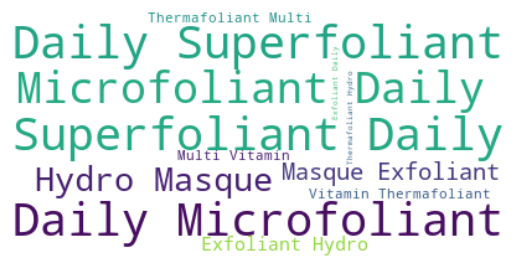

In [100]:

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(Review_Text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Qs 3. Perform sentiment analysis. Build a ML model that can predict whether a review is positive or negative.

In [101]:
# Load dataset into the environment

def load_data(filename: str, sep: str) -> "pd.DataFrame":
    """Returns the loaded dataset as pandas dataframe
    
    Params:
    filename -- str, accepts the dataset and loads as pd.DataFrame
    sep: str, separator mode accepting delimiters of the file
    Return: Pandas dataframe
    """

    # Load the dataset
    df = pd.read_csv(filename, sep=sep)
    
    # Returns the dataset
    return df

In [102]:
# Defining functions to handle various tasks

def result_comparison(Verified_Buyer_true: np.ndarray, Verified_Buyer_pred: np.ndarray) -> pd.DataFrame:
    """Returns new pandas dataframe contain true and predicted labels
    
    Params:
    Verified_Buyer_true -- np.ndarray, the initial target variable
    Verified_Buyer_pred - np.ndarray, the predicted target variable
    Return: Pandas Dataframe of the true and predicted target variables
    """
    result = pd.DataFrame()
    result["Target_initial"] = Verified_Buyer_true
    result["Target_pred"] = Verified_Buyer_pred
    result["error_term"] = Verified_Buyer_true - Verified_Buyer_pred

    return result
    

# Defining the evaluation metrics function
def eval_metrics(Verified_Buyer_actual: pd.Series, Verified_Buyer_predict: pd.Series) -> "str":
    """Returns the evaluation metrics for the model estimator
    
    Params:
    Verified_Buyer_true -- pd.Series, pandas series for the true target variable
    Verified_Buyer_pred -- pd.Series, pandas series for the predicted target variable
    Return: Scores for the evaluation metrics
    """
    
    mse = round(mean_squared_error(Verified_Buyer_true=Verified_Buyer_actual, Verified_Buyer_pred=Verified_Buyer_predict),4)
    rmse = round(mean_squared_error(Verified_Buyer_true=Verified_Buyer_actual, Verified_Buyer_pred=Verified_Buyer_predict, squared=False),4)
    mae = round(mean_absolute_error(Verified_Buyer_true=Verified_Buyer_actual, Verified_Buyer_pred=Verified_Buyer_predict),4)
    mape = round(mean_absolute_percentage_error(Verified_Buyer_true=Verified_Buyer_actual, Verified_Buyer_pred=y_predict),4)
    r2 = r2_score(Verified_Buyer_true=Verified_Buyer_actual, Verified_Buyer_pred=y_predict)

    ##############Print Result################################
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2: {r2}")



In [104]:
# Load and read dataset
df = load_data("Desktop/SGA1_4/Ulta Skincare Reviews.csv", sep=",")
df.head()

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower...,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
1,You need this,Even better than the daily microfoliant. I'm o...,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
2,Clean skin,Enjoy this product so much ! I look forward to...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
3,Love This Stuff!,I've never tried anything like this before and...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023
4,This exfoliates very nicely and,This exfoliates very nicely and gives a very s...,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/2023


In [105]:
# Check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4150 entries, 0 to 4149
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review_Title      4150 non-null   object
 1   Review_Text       4148 non-null   object
 2   Verified_Buyer    4150 non-null   object
 3   Review_Date       4150 non-null   object
 4   Review_Location   4149 non-null   object
 5   Review_Upvotes    4150 non-null   int64 
 6   Review_Downvotes  4150 non-null   int64 
 7   Product           4150 non-null   object
 8   Brand             4150 non-null   object
 9   Scrape_Date       4150 non-null   object
dtypes: int64(2), object(8)
memory usage: 324.3+ KB


In [106]:
# Subset the dataset by datatype

# Numeric variables
num_var = df.select_dtypes("number")

# Categorical variables
cat_var = df.select_dtypes("object")


In [107]:
# checking the variables making each subset
list(num_var)

['Review_Upvotes', 'Review_Downvotes']

In [108]:
# Categorical variables
cat_var.columns

Index(['Review_Title', 'Review_Text', 'Verified_Buyer', 'Review_Date',
       'Review_Location', 'Product', 'Brand', 'Scrape_Date'],
      dtype='object')

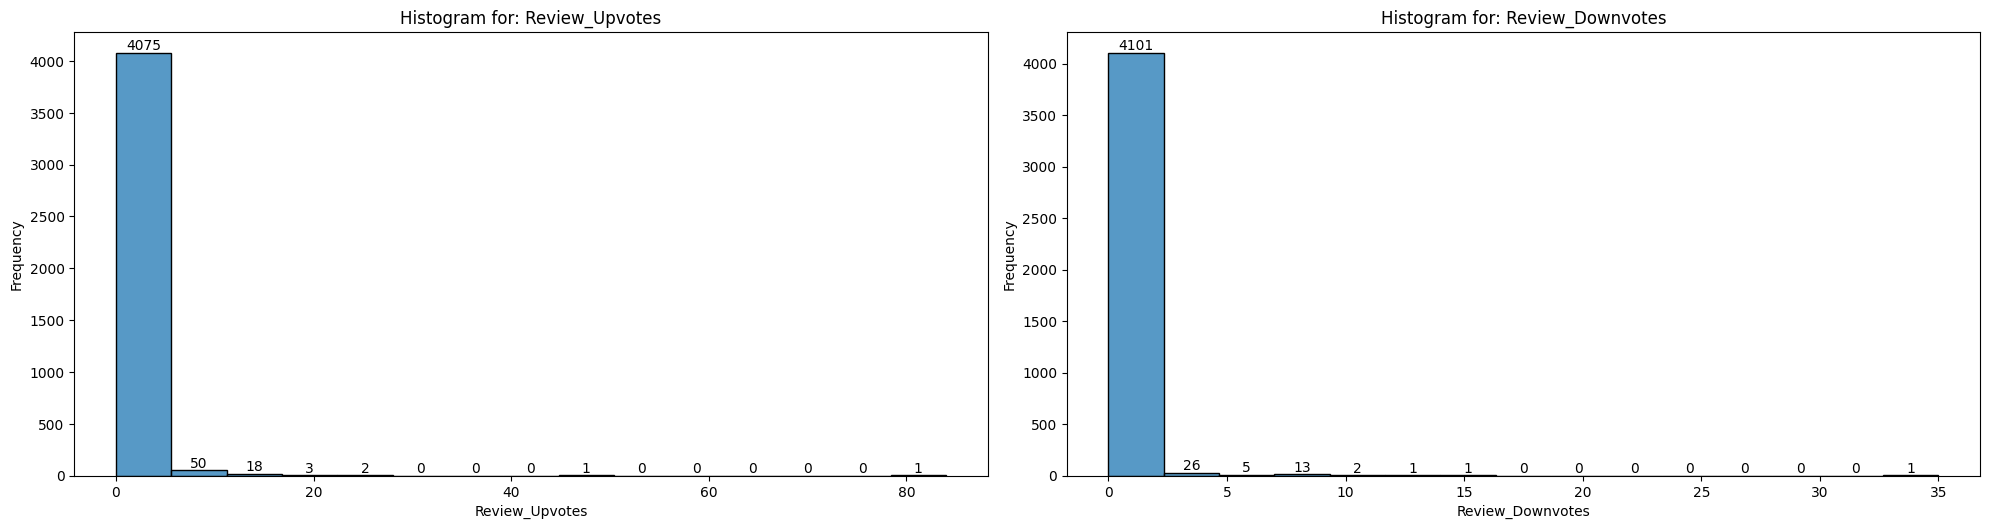

In [111]:
# Creating functions for numeric variables plots
def num_plot(data: pd.DataFrame, features: list[str]) -> 'plots':
    """Returns histogram for numeric data

    Params:
        data :pd.DataFrame, returns the loaded data
        features: list[str], returns list of features
    """
    plt.figure(figsize=(20,15))
    for i, feat in enumerate(features):
        base_color = sns.color_palette()[0]
        plt.subplot(3,2,i+1)
        axs = sns.histplot(data=data, x=feat, color = base_color, bins=15)
        axs.bar_label(axs.containers[0])
        axs.set_title(f"Histogram for: {feat}")
        axs.set_xlabel(f"{feat}")
        axs.set_ylabel('Frequency')

    plt.tight_layout();

# Run the function
# Plot numeric variables
num_plot(data=df, features=num_var.columns)